In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.sandbox.stats.runs as runs
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# 数据预处理

将match_id重新搞成易读取的形式

将时间戳化为秒

网球比赛给分不均衡，可能会影响我们的计算，故将其均衡化，即0,1,2,3,4对应0,15,30,40,ad

In [28]:
data = pd.read_csv('Wimbledon_featured_matches.csv')

# 修改时间戳
def time_trans(time):
    hours, minutes, seconds = map(int, time.split(':'))
    return hours*3600+minutes*60+seconds

data['elapsed_time'] = data['elapsed_time'].apply(time_trans)

# 修改id
idDict = {}
for id in data['match_id'].unique():
    if id not in idDict:
        idDict[id] = len(idDict)
data['match_id'] = data['match_id'].map(idDict)

# 修改得分
scoreDict = {'0': 0, '15': 1, '30': 2, '40': 3, 'AD': 4, '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10}
data['p1_score'] = data['p1_score'].map(scoreDict)
data['p2_score'] = data['p2_score'].map(scoreDict)

# 网球比赛的比分

## 一局

（1）每胜1球得1分，先胜4分者胜1局。
（2）双方各得3分时为“平分”，平分后，净胜两分为胜1局。国际网球赛都是用英语单词Love，以及数字15、30、40分别表示0、1、3、4。

## 一盘

（1）一方先胜6局为胜1盘。
（2）双方各胜5局时，一方净胜两局为胜1盘

### 决胜局计分制

在每盘的局数为6平时，有以下两种计分制。
（1）长盘制：一方净胜两局为胜1盘。
（2）短盘制（抢七）：决胜盘除外，除非赛前另有规定，一般应按以下办法执行。

A.先得7分者为胜该局及该盘（若分数为6平时，一方须净两分）。
B.首先发球员发第1分球，对方发第2、3分球，然后轮流发两分球，直到比赛 结束。
C.第1分球在右区发，第2分球在左区发，第3分球在右区发。
D.每6分球和决胜局结束都要交换场地。

短盘制的计分
（1）第1个球（0：0），发球员A发1分球，1分球之后换发球。
（2）第2、3个球（报1：0或0：1，不报15：0或0：15），由B发球，B连发两分球后换发球，先从左区发球。
（3）第4、5个球（报3：0或1：2，2：1，不报40：0或15：30， 30：15），由A发球，A连发两球后换发球后换发球，先从左区发球。
（4）第6、7个球（报3：3或2：4，4：2或1：5，5：1或6：0，0： 6） ，由B发1分球之后交换场地，若比赛未结束，B继续发第7个球。
（5）比分打到5：5，6：6，7：7，8：8……时，需连胜两分才能决定谁为胜方。但在记分表上则统一写为7：6。
（6）决胜局打完之后，双方队员交换场地。

五盘三胜制度

# 题目1

1. 给出整个比赛流程中哪一个更好的模型（以及好了多少），并对比赛流程进行可视化。

# 思路

先基于分差给出一个表现上的结果。

（根据tandf_cjas2048_2982中论文内容）momentum：两次击球后分差（短期表现）。下面图一给出全局player1的分差。（player2为相反数）图二给出每一局游戏的分差。虚线是小局之间的分割线。

若分差呈上升趋势，则player1表现好，若下降趋势，则player2表现好



0     -1.0
1      0.0
2     -1.0
3      0.0
4      1.0
      ... 
295    0.0
296   -1.0
297    0.0
298    1.0
299    2.0
Name: momentum, Length: 300, dtype: float64

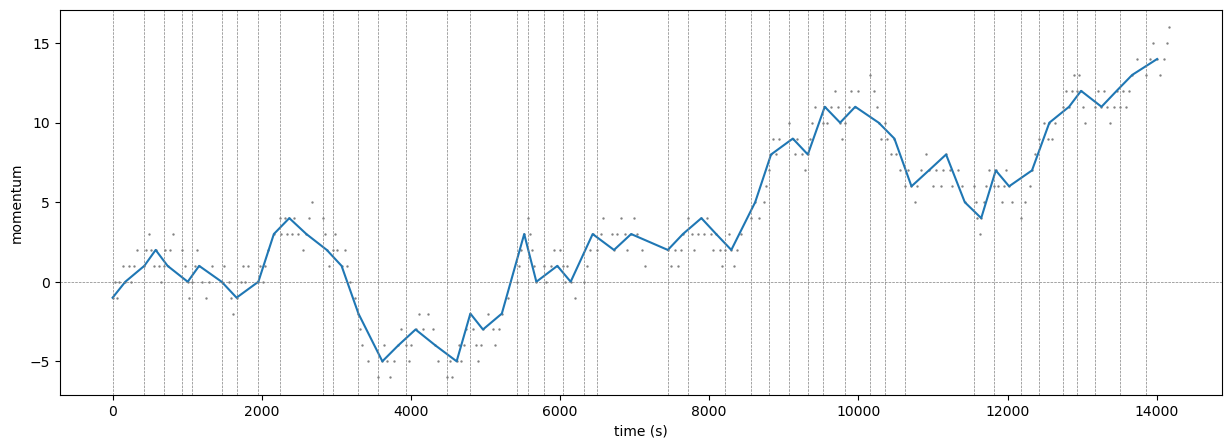

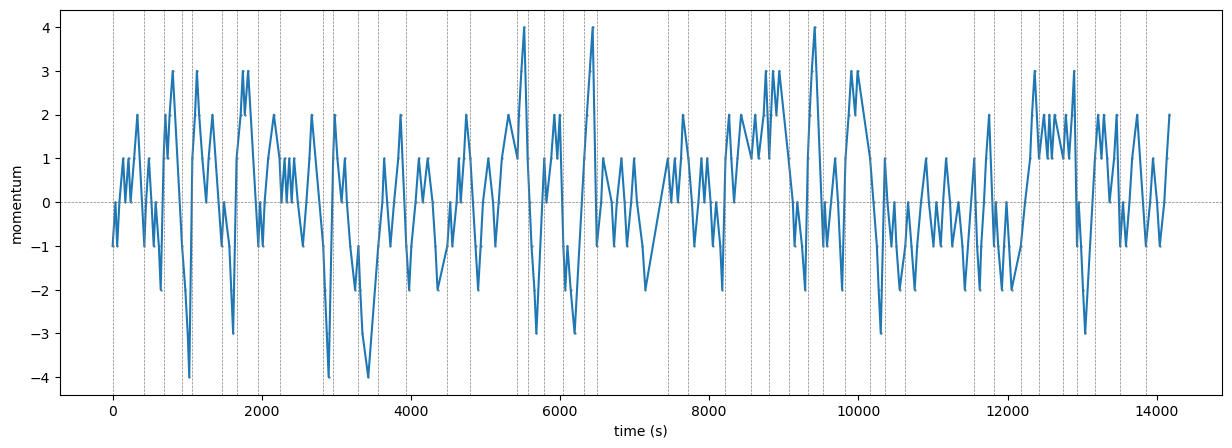

In [29]:
def dataCal(gameData, interval):
    pointErr = np.zeros(gameData.shape[0])
    sumOfPoint1 = 0
    sumOfPoint2 = 0
    j = 0
    for j in range(0,gameData.shape[0]):
        if gameData['point_victor'].iloc[j] == 1:
            sumOfPoint1 += 1
        if gameData['point_victor'].iloc[j] == 2:
            sumOfPoint2 += 1
        pointErr[j] = sumOfPoint1 - sumOfPoint2
    examplingPointErr = np.zeros((int)(np.floor(gameData.shape[0]/interval)))
    examplingTime = np.zeros((int)(np.floor(gameData.shape[0]/interval)))
    for counter in range(0,(int)(np.floor(gameData.shape[0]/interval))):
        examplingPointErr[counter] = pointErr[counter*interval]
        examplingTime[counter] = gameData['elapsed_time'].iloc[counter*interval]
    xyData = pd.DataFrame()
    exyData = pd.DataFrame()
    xyData['time'] = gameData['elapsed_time']
    xyData['momentum'] = pointErr
    exyData['momentum'] = examplingPointErr
    exyData['time'] = examplingTime
    return xyData, exyData

def drawFig(gameData, xyData, exyData, filename):
    diff = np.diff(xyData['time'])
    breakPoints = [0]
    if np.max(diff) > 3600:
        breakPoints = np.where(diff > 3600)[0]
    if breakPoints[0] != 0:
        fig0, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
        ax1.set_xlim(xyData['time'].min(), xyData['time'].iloc[breakPoints[0]])
        ax2.set_xlim(xyData['time'].iloc[breakPoints[0]+1],xyData['time'].max())
        ax1.spines.right.set_visible(False)
        ax2.spines.left.set_visible(False)
        ax2.tick_params(left=False)
        ax1x, ax2x = xyData['time'].iloc[0:breakPoints[0]], xyData['time'].iloc[breakPoints[0]+1:]
        ax1y, ax2y = xyData['momentum'].iloc[0:breakPoints[0]], xyData['momentum'].iloc[breakPoints[0]+1:]
        diff = np.diff(exyData['time'])
        breakPoints = np.where(diff > 3600)[0]
        ax1ex, ax2ex = exyData['time'].iloc[0:breakPoints[0]], exyData['time'].iloc[breakPoints[0]+1:]
        ax1ey, ax2ey = exyData['momentum'].iloc[0:breakPoints[0]], exyData['momentum'].iloc[breakPoints[0]+1:]
        ax1.plot(ax1ex, ax1ey)
        ax2.plot(ax2ex, ax2ey)
        ax1.scatter(ax1x, ax1y, s=2,marker='.',c='grey')
        ax2.scatter(ax2x, ax2y, s=2,marker='.',c='grey')
        ax1.axhline(0,color='grey',linestyle='--',linewidth=0.5)
        ax2.axhline(0,color='grey',linestyle='--',linewidth=0.5)
        ax1.set_xlabel('time (s)')
        ax2.set_xlabel('time (s)')
        ax1.set_ylabel('momentum')
    else:
        fig0, ax = plt.subplots(figsize=(15, 5))
        ax.scatter(xyData['time'],xyData['momentum'],s=2,marker='.',c='grey')
        ax.plot(exyData['time'],exyData['momentum'])
        ax.axhline(0,color='grey',linestyle='--',linewidth=0.5)
        ax.set_xlabel('time (s)')
        ax.set_ylabel('momentum')
    gameStart = gameData[(gameData['p1_score'] == 0)&(gameData['p2_score']==0)]['elapsed_time']
    for xAxis in gameStart:
        ax.axvline(xAxis,color='grey',linestyle='--',linewidth=0.5)
    momentum = xyData['momentum']
    plt.savefig(filename)
    return momentum
gameData = data[data['match_id'] == 0]
xyData, exyData = dataCal(gameData, 5)
drawFig(gameData, xyData, exyData, 'fig0_0.pdf')
xyDataGame = pd.DataFrame()
exyDataGame = pd.DataFrame()
# 对于每一场比赛的小局
for i in range(1,np.max(gameData['set_no'])+1):
    for k in range(1,np.max(gameData[gameData['set_no'] == i]['game_no'])+1):
        gameDataInGame = gameData[(gameData['set_no'] == i)&(gameData['game_no'] == k)]
        xyData, exyData = dataCal(gameDataInGame, 1)
        xyDataGame = pd.concat([xyDataGame, xyData])
        exyDataGame = pd.concat([exyDataGame, exyData])
drawFig(gameData, xyDataGame, exyDataGame, 'fig1_0.pdf')

显然只靠分差是不全面的。我们再对"冲劲"进行修正，只需略微修改数据计算的代码。加入下面的修正：

- 先手修正：概率性提高分差，若自己先手，加上先手发球得分概率；若对方先手，减去对方先手发球得分概率
- ace球修正：会影响士气，自己出ace，提高0.5，对方出，减少0.5

表现仍然是看冲劲的趋势

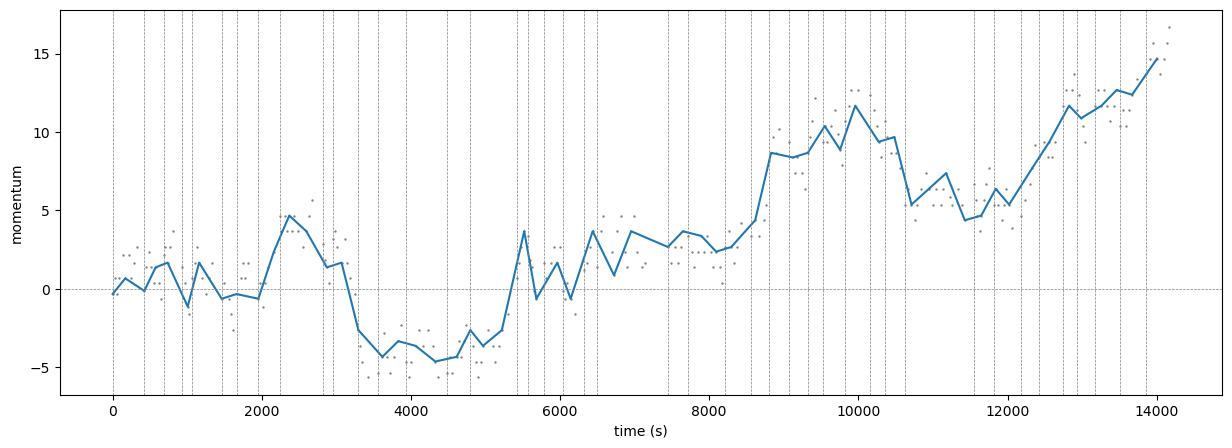

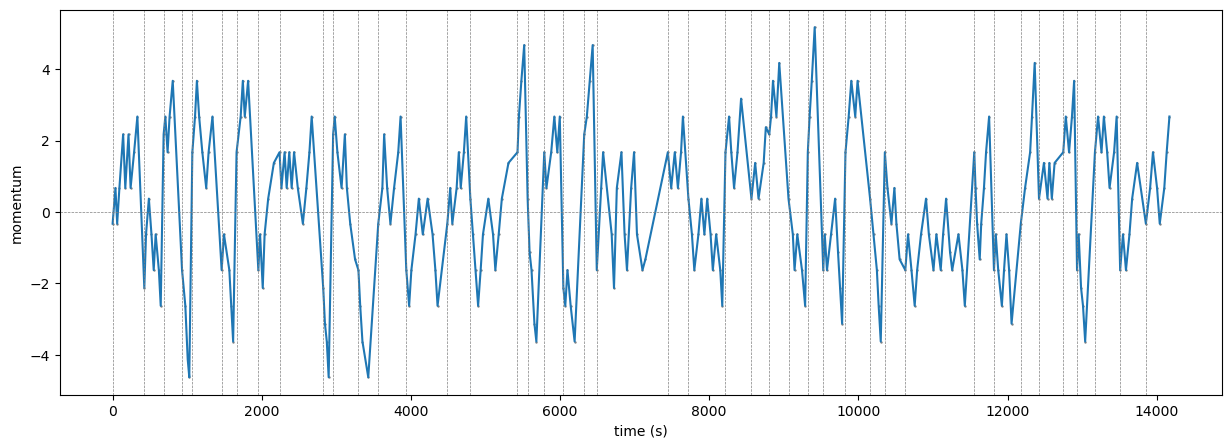

In [30]:
def dataCalF(gameData, interval, playerFirst):
    pointErr = np.zeros(gameData.shape[0])
    sumOfPoint1 = 0
    sumOfPoint2 = 0
    j = 0
    for j in range(0,gameData.shape[0]):
        if gameData['point_victor'].iloc[j] == 1:
            sumOfPoint1 += 1
        if gameData['point_victor'].iloc[j] == 2:
            sumOfPoint2 += 1
        pointErr[j] = sumOfPoint1 - sumOfPoint2
    momentum = pointErr
    for i in range(0,gameData.shape[0]):
        if gameData['server'].iloc[i] == 1:
            momentum[i] += playerFirst[0]
        if gameData['server'].iloc[i] == 2:
            momentum[i] -= playerFirst[1]
    for i in range(0,gameData.shape[0]):
        if gameData['p1_ace'].iloc[i] == 1:
            momentum[i] += 0.5
        if gameData['p2_ace'].iloc[i] == 1:
            momentum[i] -= 0.5
    examplingMomentum = np.zeros((int)(np.floor(gameData.shape[0]/interval)))
    examplingTime = np.zeros((int)(np.floor(gameData.shape[0]/interval)))
    for counter in range(0,(int)(np.floor(gameData.shape[0]/interval))):
        examplingMomentum[counter] = momentum[counter*interval]
        examplingTime[counter] = gameData['elapsed_time'].iloc[counter*interval]
    xyData = pd.DataFrame()
    exyData = pd.DataFrame()
    xyData['time'] = gameData['elapsed_time']
    xyData['momentum'] = momentum
    exyData['momentum'] = examplingMomentum
    exyData['time'] = examplingTime
    return xyData, exyData

def matchDataCal(gameData):
    player1First = gameData[(gameData['point_victor'] == 1)&(gameData['server'] == 1)].shape[0]/gameData[gameData['server'] == 1].shape[0]
    player2First = gameData[(gameData['point_victor'] == 2)&(gameData['server'] == 2)].shape[0]/gameData[gameData['server'] == 2].shape[0]
    playerFirst = [player1First, player2First]
    aceData = np.zeros(gameData.shape[0])
    return playerFirst

gameData = data[data['match_id'] == 0]
playerFirst = matchDataCal(gameData)
xyData, exyData = dataCalF(gameData, 5, playerFirst)
drawFig(gameData, xyData, exyData, 'fig2_0.pdf')
xyDataGame = pd.DataFrame()
exyDataGame = pd.DataFrame()
# 对于每一场比赛的小局
for i in range(1,np.max(gameData['set_no'])+1):
    for k in range(1,np.max(gameData[gameData['set_no'] == i]['game_no'])+1):
        gameDataInGame = gameData[(gameData['set_no'] == i)&(gameData['game_no'] == k)]
        xyData, exyData = dataCalF(gameDataInGame, 1, playerFirst)
        xyDataGame = pd.concat([xyDataGame, xyData])
        exyDataGame = pd.concat([exyDataGame, exyData])
momentum = drawFig(gameData, xyDataGame, exyDataGame, 'fig3_0.pdf')

2. 反驳网球教练的势头随机的观点（反驳转折和连胜是随机的）

前面提到过势头的上升下降趋势反映表现，我们可以将上升趋势与下降趋势的转折定义为转折点。在每一局比赛中，通过线性拟合本局比赛player1的总体表现与第几个球得到反应上升下降趋势的斜率，当表现转变（斜率正负改变时）转折点出现。为了平衡那些趋势几乎不变的非转折数据的影响，规定斜率低于一个阈值才算转折（-0.15）。我们在图上用红色竖线标出这些点

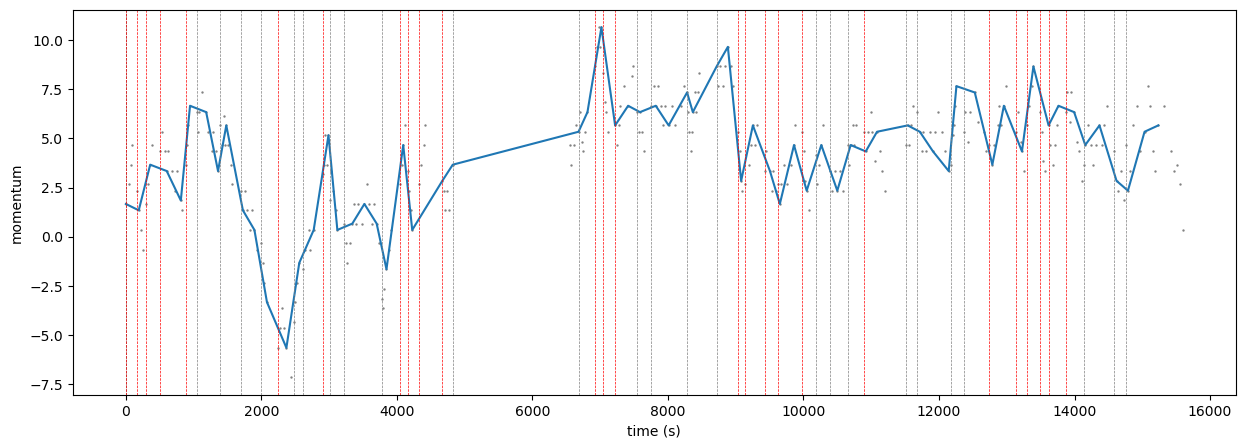

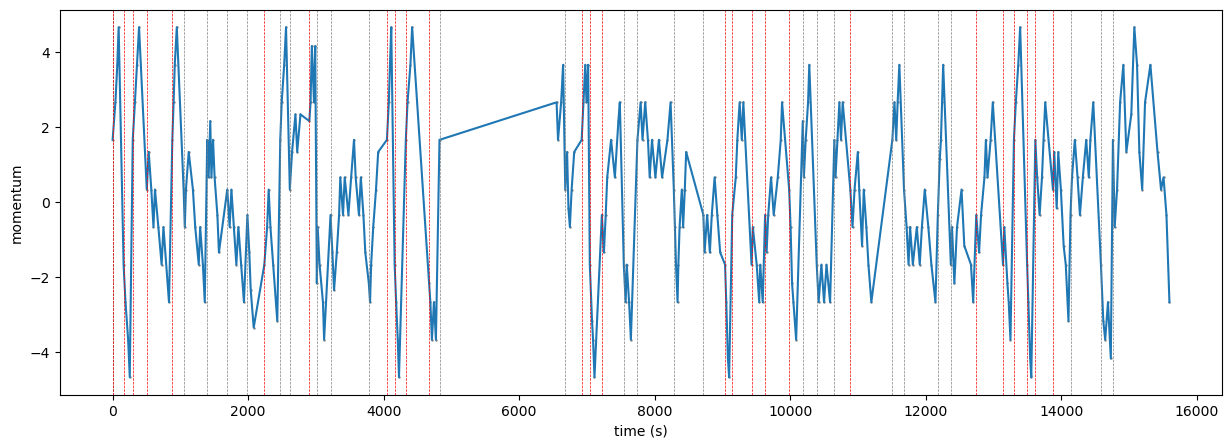

In [5]:
gameData = data[data['match_id'] == 3]
playerFirst = matchDataCal(gameData)
slope = []
timelist = [0]
for i in range(1,np.max(gameData['set_no'])+1):
    for k in range(1,np.max(gameData[gameData['set_no'] == i]['game_no'])+1):
        gameDataInGame = gameData[(gameData['set_no'] == i)&(gameData['game_no'] == k)]
        xyData, exyData = dataCalF(gameDataInGame, 1, playerFirst)
        ps = np.polyfit(list(range(0,xyData['time'].shape[0])),xyData['momentum'],1)
        timelist.append(np.min(xyData['time']))
        slope.append(ps[0])
turningPoint = np.zeros(len(timelist))
for i in range(1,len(slope)):
    if slope[i]*slope[i-1] < -0.1:
        turningPoint[i] = 1

def drawFigF(gameData, xyData, exyData, turningPoint, filename):
    diff = np.diff(xyData['time'])
    breakPoints = [0]
    if np.max(diff) > 3600:
        breakPoints = np.where(diff > 3600)[0]
    if breakPoints[0] != 0:
        fig0, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
        breakPointsGame = 0
        for i in range(1,len(timelist)):
            if (timelist[i-1] < xyData['time'].iloc[breakPoints[0]]) & (timelist[i] >= xyData['time'].iloc[breakPoints[0]]):
                breakPointsGame = i
        ax1t, ax2t = turningPoint[0:breakPointsGame], turningPoint[breakPointsGame+1:]
        ax1.set_xlim(xyData['time'].min(), xyData['time'].iloc[breakPoints[0]])
        ax2.set_xlim(xyData['time'].iloc[breakPoints[0]+1],xyData['time'].max())
        ax1.spines.right.set_visible(False)
        ax2.spines.left.set_visible(False)
        ax2.tick_params(left=False)
        ax1x, ax2x = xyData['time'].iloc[0:breakPoints[0]], xyData['time'].iloc[breakPoints[0]+1:]
        ax1y, ax2y = xyData['momentum'].iloc[0:breakPoints[0]], xyData['momentum'].iloc[breakPoints[0]+1:]
        diff = np.diff(exyData['time'])
        breakPoints = np.where(diff > 3600)[0]
        ax1ex, ax2ex = exyData['time'].iloc[0:breakPoints[0]], exyData['time'].iloc[breakPoints[0]+1:]
        ax1ey, ax2ey = exyData['momentum'].iloc[0:breakPoints[0]], exyData['momentum'].iloc[breakPoints[0]+1:]
        ax1.plot(ax1ex, ax1ey)
        ax2.plot(ax2ex, ax2ey)
        ax1.scatter(ax1x, ax1y, s=2,marker='.',c='grey')
        ax2.scatter(ax2x, ax2y, s=2,marker='.',c='grey')
        ax1.axhline(0,color='grey',linestyle='--',linewidth=0.5)
        ax2.axhline(0,color='grey',linestyle='--',linewidth=0.5)
        for i in range(0,len(ax1t)):
            if ax1t[i] == 1:
                ax1.axvline(timelist[i],color='red',linestyle='--',linewidth=0.5)
            else:
                ax1.axvline(timelist[i],color='grey',linestyle='--',linewidth=0.5)
        for i in range(0,len(ax2t)):
            if ax2t[i] == 1:
                ax2.axvline(timelist[-len(ax2t)+i],color='red',linestyle='--',linewidth=0.5)
            else:
                ax2.axvline(timelist[-len(ax2t)+i],color='grey',linestyle='--',linewidth=0.5)
        ax1.set_xlabel('time (s)')
        ax2.set_xlabel('time (s)')
        ax1.set_ylabel('momentum')
    else:
        fig0, ax = plt.subplots(figsize=(15, 5))
        ax.scatter(xyData['time'],xyData['momentum'],s=2,marker='.',c='grey')
        ax.plot(exyData['time'],exyData['momentum'])
        ax.axvline(0,color='grey',linestyle='--',linewidth=0.5)
        for i in range(0,len(timelist)):
            if turningPoint[i] == 1:
                ax.axvline(timelist[i],color='red',linestyle='--',linewidth=0.5)
            else:
                ax.axvline(timelist[i],color='grey',linestyle='--',linewidth=0.5)
        ax.set_xlabel('time (s)')
        ax.set_ylabel('momentum')
    plt.savefig(filename)
    momentum = xyData['momentum']
    return momentum

xyData, exyData = dataCalF(gameData, 5, playerFirst)
drawFigF(gameData, xyData, exyData, turningPoint, 'fig4_3.pdf')
xyDataGame = pd.DataFrame()
exyDataGame = pd.DataFrame()
# 对于每一场比赛的小局
for i in range(1,np.max(gameData['set_no'])+1):
    for k in range(1,np.max(gameData[gameData['set_no'] == i]['game_no'])+1):
        gameDataInGame = gameData[(gameData['set_no'] == i)&(gameData['game_no'] == k)]
        xyData, exyData = dataCalF(gameDataInGame, 1, playerFirst)
        xyDataGame = pd.concat([xyDataGame, xyData])
        exyDataGame = pd.concat([exyDataGame, exyData])
momentum = drawFigF(gameData, xyDataGame, exyDataGame, turningPoint, 'fig5_3.pdf')


对转折点进行随机性检验，使用runs test

In [6]:
pvs = np.zeros(np.max(data['match_id']))
zs = np.zeros(np.max(data['match_id']))
for matchNum in range(0,np.max(data['match_id'])):
    gameData = data[data['match_id'] == matchNum]
    slope = []
    timelist = [0]
    for i in range(1,np.max(gameData['set_no'])+1):
        for k in range(1,np.max(gameData[gameData['set_no'] == i]['game_no'])+1):
            gameDataInGame = gameData[(gameData['set_no'] == i)&(gameData['game_no'] == k)]
            xyData, exyData = dataCalF(gameDataInGame, 1, playerFirst)
            ps = np.polyfit(list(range(0,xyData['time'].shape[0])),xyData['momentum'],1)
            timelist.append(np.min(xyData['time']))
            slope.append(ps[0])
    turningPoint = np.zeros(len(timelist))
    for i in range(1,len(slope)):
        if slope[i]*slope[i-1] < -0.1:
            turningPoint[i] = 1
    zs[matchNum], pvs[matchNum] = runs.runstest_1samp(turningPoint, cutoff=0.5)
print(pvs,zs)

[9.85967599e-01 2.27802445e-02 1.06565305e-01 5.09289421e-03
 2.07811298e-02 1.20922843e-03 1.62941987e-01 4.00274242e-02
 4.84316745e-02 9.10825662e-01 9.81670268e-05 6.82273608e-04
 4.46441597e-01 6.83296802e-02 1.20549963e-01 2.21800894e-02
 1.83405840e-01 7.38557793e-02 1.59099530e-01 1.08383666e-01
 5.56945320e-01 3.20791105e-01 6.86536986e-03 9.63454911e-02
 1.20549963e-01 9.94388527e-05 2.96269871e-01 1.83405840e-01
 4.46593656e-01 3.40899587e-02] [ 0.01758791 -2.27710017 -1.61382539 -2.80109869 -2.31193746 -3.23669437
 -1.39524495 -2.05346579 -1.97356107 -0.11199716 -3.89507827 -3.39660506
 -0.7613608  -1.82282645 -1.55246934 -2.28726964 -1.33034132 -1.78750578
 -1.40810652 -1.60550067 -0.58738477 -0.99283349 -2.70330509 -1.66283489
 -1.55246934 -3.89195705 -1.04446594 -1.33034132 -0.76110617 -2.11900601]


runs test的p value很低，在多场次比赛中，runs test的p value低于0.05，这说明拒绝随机性假设，也就时说，转折点的分布没有随机性。（至少在很多场次中都可以体现出没有随机性）同时，多场的test statistic也是一个较小的负数，进一步说明转折点的分布无随机性。

为计算概率，需要一些特征。
上几次击球的得分结果：(长期表现)或许总进球概率是一个可行的值，不过为了让其更可靠，固定选择发球（或不发球）是的概率

特征工程做好了

In [16]:
try:
    del exyData, exyDataGame, gameData, gameDataInGame, i, id, idDict, k, matchNum, ps, pvs, scoreDict, slope, timelist, turningPoint, xyData, xyDataGame, zs
except:
    print('ok')

featureData = pd.read_csv('feature_engineering/ver2/feature1result1.csv')
trainingData = pd.DataFrame()
idDict = {}
for id in featureData['match_id'].unique():
    if id not in idDict:
        idDict[id] = len(idDict)
featureData['match_id'] = featureData['match_id'].map(idDict)

# 计算动量
momentumAll = np.ndarray((0,1))
for i in range(0,np.max(data['match_id'])+1):
    temp, _ = dataCalF(data[data['match_id']==i],5,playerFirst)
    temp = temp['momentum']
    momentumAll = np.append(momentumAll, temp)
featureData['momentum'] = momentumAll

featureData['point_victor'] = data['point_victor']

featureData = featureData.drop('p1servespeedindex', axis=1)
featureData = featureData.drop('p2servespeedindex', axis=1)

# 特征的第一条都不能用
trainingData = featureData.groupby('match_id').tail(-1)
featureNp = trainingData.iloc[:,12:45].values
resultNp = trainingData.iloc[:,45].values - 1

feature = torch.from_numpy(featureNp).type(torch.float)
result = torch.from_numpy(resultNp).type(torch.float)
featureTr, featureTe, resultTr, resultTe = train_test_split(feature, result, test_size=0.2)

ok


模型在下面：

In [17]:
seed = 12
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# 两层线性模型
class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_size = feature.shape[1]
hidden_size = 256
output_size = 1
learning_rate = 0.0005
num_epochs = 1000

lossPrint = np.zeros((num_epochs,1))

model = RegressionModel(input_size, hidden_size, output_size)

# 用MSE做损失函数
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 训练
for epoch in range(num_epochs):
    outputs = model(featureTr)
    loss = criterion(outputs, resultTr.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lossPrint[epoch] = loss.item()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

with torch.no_grad():
    predicted = model(featureTe)
    mse = criterion(predicted, resultTe.unsqueeze(1))
    print(f'Mean Squared Error: {mse.item():.4f}')

Epoch [100/1000], Loss: 0.2763
Epoch [200/1000], Loss: 0.2564
Epoch [300/1000], Loss: 0.2437
Epoch [400/1000], Loss: 0.2354
Epoch [500/1000], Loss: 0.2301
Epoch [600/1000], Loss: 0.2264
Epoch [700/1000], Loss: 0.2235
Epoch [800/1000], Loss: 0.2215
Epoch [900/1000], Loss: 0.2201
Epoch [1000/1000], Loss: 0.2189
Mean Squared Error: 0.2287


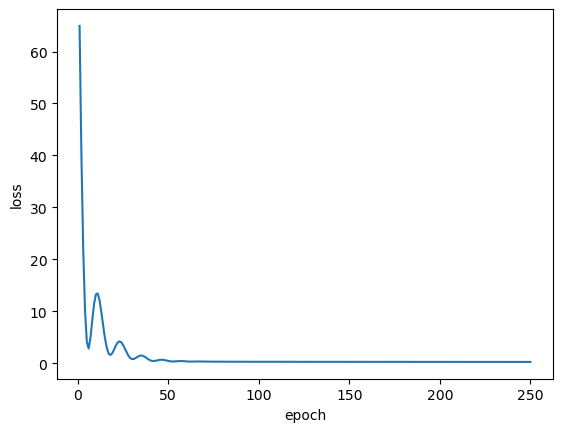

In [18]:
fig, ax = plt.subplots()
ax.plot(list(range(1,251)),lossPrint[0:250])
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.savefig('fig6.pdf')

In [21]:
model.eval()

# 使用第一场比赛测试模型(丢掉第一个)
inputData = featureData[featureData['match_id'] == 3]
inputData = inputData.iloc[1:]
modelInput = torch.from_numpy(inputData.iloc[:,12:45].values).type(torch.float)
gameData = data[data['match_id'] == 3]

predictions = model(modelInput)

在prediction中，值越接近1,player2得分的可能性越大，越接近0，player1得分的可能性越大。认为可能性大的一方就是那一方得分，阈值为0.5，得到准确性

0.6339285714285714


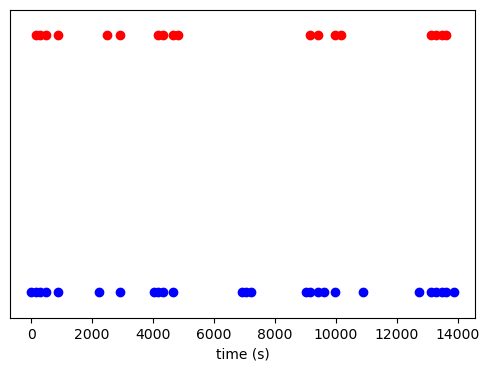

In [22]:
predictionsNp = predictions.detach().numpy()
predictionsNp = np.append([0],predictionsNp)

pointPred = np.zeros(predictionsNp.shape[0])
for i in range(1,pointPred.shape[0]):
    if predictionsNp[i] > 0.5:
        pointPred[i] = 2
    else:
        pointPred[i] = 1
pointPred[0] = 1.5

accuracy = 0
right = 0
for i in range(1,pointPred.shape[0]):
    if pointPred[i] == gameData['point_victor'].iloc[i]:
        right += 1
accuracy = right / (pointPred.shape[0] - 1)
print(accuracy)

slope = []
timelist = [0]
for i in range(1,np.max(gameData['set_no'])+1):
    for k in range(1,np.max(gameData[gameData['set_no'] == i]['game_no'])+1):
        gameDataInGame = gameData[(gameData['set_no'] == i)&(gameData['game_no'] == k)]
        xyData, exyData = dataCalF(gameDataInGame, 1, playerFirst)
        ps = np.polyfit(list(range(0,xyData['time'].shape[0])),xyData['momentum'],1)
        timelist.append(np.min(xyData['time']))
        slope.append(ps[0])
turningPoint = np.zeros(len(timelist))
for i in range(1,len(slope)):
    if slope[i]*slope[i-1] < -0.1:
        turningPoint[i] = 1
slope = []
turningPointP = np.zeros(len(timelist))
for i in range(1,np.max(gameData['set_no'])+1):
    for k in range(1,np.max(gameData[gameData['set_no'] == i]['game_no'])+1):
        gameDataInGame = gameData[(gameData['set_no'] == i)&(gameData['game_no'] == k)]
        ps = np.polyfit(list(range(0,gameDataInGame['elapsed_time'].shape[0])), predictionsNp[(gameData['set_no'] == i)&(gameData['game_no'] == k)],1)
        slope.append(ps[0])
for i in range(1,len(slope)):
    if slope[i]*slope[i-1] < -0.001:
        turningPointP[i] = 1
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_ylim(-0.1,1.1)
for i in range(0,len(timelist)):
    if turningPoint[i] == 1:
        ax.scatter(timelist[i],0,color='blue')
    if turningPointP[i] == 1:
        ax.scatter(timelist[i],1,color='red')
ax.get_yaxis().set_visible(False)
ax.set_xlabel('time (s)')
plt.savefig('fig7_3.pdf')

下面尝试做分类：

In [23]:
featureData = pd.read_csv('feature_engineering/ver2/finalfeature2_first_one_of_each_match_useless.csv')
featureData['match_id'] = data['match_id']
trainingData = pd.DataFrame()
idDict = {}
for id in featureData['match_id'].unique():
    if id not in idDict:
        idDict[id] = len(idDict)
featureData['match_id'] = featureData['match_id'].map(idDict)

# 计算动量
momentumAll = np.ndarray((0,1))
for i in range(0,np.max(data['match_id'])+1):
    temp, _ = dataCalF(data[data['match_id']==i],1,playerFirst)
    temp = temp['momentum']
    momentumAll = np.append(momentumAll, temp)
featureData['momentum'] = momentumAll

featureData['point_victor'] = data['point_victor']

# 特征的第一条都不能用
trainingData = featureData.groupby('match_id').tail(-1)

featureNp = trainingData.iloc[:,1:13].values
resultNp = trainingData.iloc[:,-1].values - 1

feature = torch.from_numpy(featureNp).type(torch.float)
result = torch.from_numpy(resultNp).type(torch.long)
featureTr, featureTe, resultTr, resultTe = train_test_split(feature, result, test_size=0.2)

In [26]:
seed = 12
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Define the classification model
class ClassificationModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Set the hyperparameters
input_size = feature.shape[1]
hidden_size = 256
output_size = 2
learning_rate = 0.001
num_epochs = 300

lossPrint = np.zeros((num_epochs,1))

# Create an instance of the classification model
model = ClassificationModel(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(featureTr)
    loss = criterion(outputs, resultTr)

    lossPrint[epoch] = loss.item()

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss every 100 epochs
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    # Forward pass on the testing set
    outputs = model(featureTe)
    _, predicted = torch.max(outputs.data, 1)

    # Calculate the accuracy
    accuracy = (predicted == resultTe).sum().item() / resultTe.size(0)
    print(f'Accuracy: {accuracy:.4f}')


Epoch [50/300], Loss: 0.6578
Epoch [100/300], Loss: 0.6530
Epoch [150/300], Loss: 0.6490
Epoch [200/300], Loss: 0.6443
Epoch [250/300], Loss: 0.6393
Epoch [300/300], Loss: 0.6342
Accuracy: 0.6396


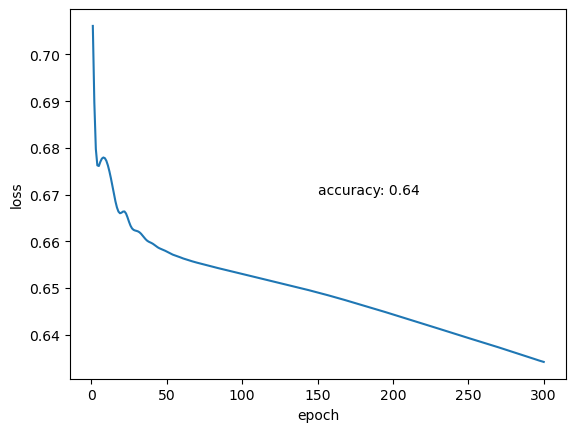

In [27]:
fig, ax = plt.subplots()
ax.plot(list(range(1,301)),lossPrint[0:300])
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.text(150,0.67,'accuracy: %.2f' %accuracy)
plt.savefig('fig8.pdf')